<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm, trange
import time
import gc

%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
data, attrs = fetch_dataset()

In [4]:
data.shape

(13143, 64, 64, 3)

In [5]:
attrs.shape

(13143, 73)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
data_train, data_val, attrs_train, attrs_val = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=32)

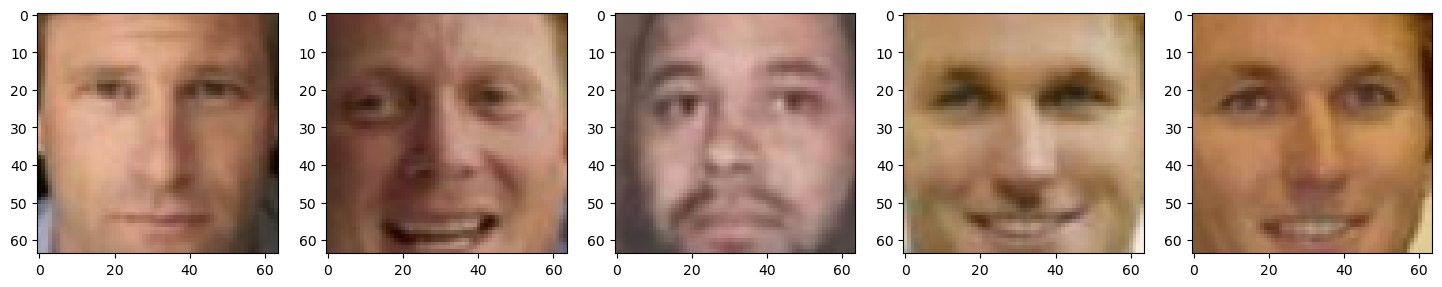

In [7]:
plt.figure(figsize=(18, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(data_train[i])

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [8]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
                    nn.Linear(12288, 6144),
                    nn.ReLU(),
                    nn.Linear(6144, 512),
                    nn.ReLU(),
                    nn.Linear(512, 30)
                    )
#         self.encoder = nn.Sequential(
#                         nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2),
#                         nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2),
#                         nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2),
#                         nn.Flatten(),
#                         nn.Linear(4096, 2048),
#                         nn.Linear(2048, 16)
#                         )
#         self.decoder1 = nn.Sequential(
#                         nn.Linear(16, 2048),
#                         nn.Linear(2048, 4096))
                        
#         self.decoder2 = nn.Sequential(
#                         nn.ConvTranspose2d(64,32,9),
#                         nn.ConvTranspose2d(32,16,17),# -> 16/16/32
#                         nn.ConvTranspose2d(16,3,33))
        self.decoder = nn.Sequential(
                    nn.Linear(30, 512),
                    nn.ReLU(),
                    nn.Linear(512, 6144),
                    nn.ReLU(),
                    nn.Linear(6144, 12288)
                    )

#     def forward(self, x):
#         x = self.flatten(x).float()
#         latent_code = self.encoder(x)
#         z = self.decoder1(latent_code)
#         z = z.view(-1,64, 8, 8)
#         reconstruction = self.decoder2(z)
#         return  reconstruction.transpose(1,2).transpose(2,3), latent_code 
    def forward(self, x ):
        x = self.flatten(x).float()
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        #reconstruction = torch.sigmoid(reconstruction)
        return  reconstruction, latent_code
    
    def sample(self, x):
        reconstruction = self.decoder(x)
        return  reconstruction

## 1.3 Обучение (2 балла)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataloaders = {'train': train_loader , 'val': val_loader}

modes = ['train', 'val']

criterion = nn.MSELoss()

model = Autoencoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4 )

n_epochs = 30

train_loss = []
val_loss = []

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


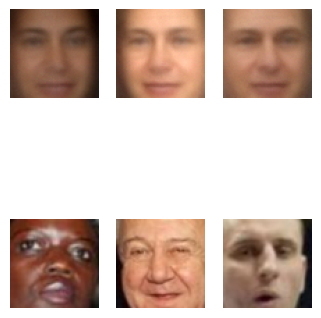

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


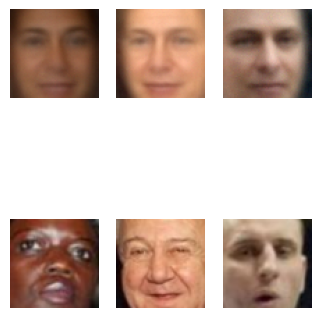

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

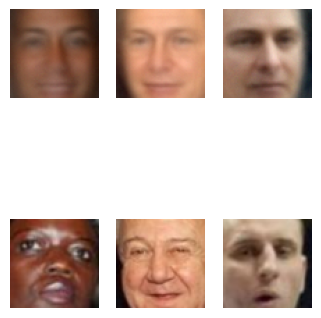

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


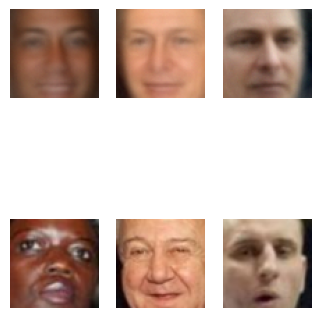

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


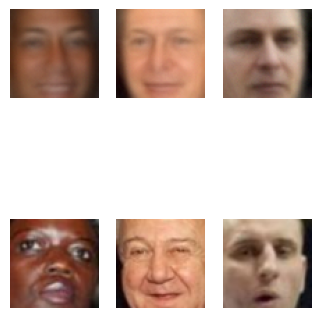

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


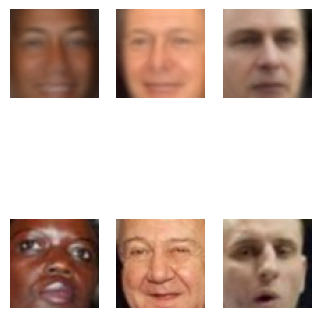

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


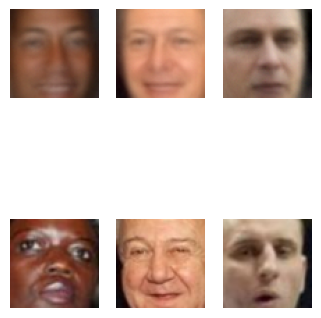

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


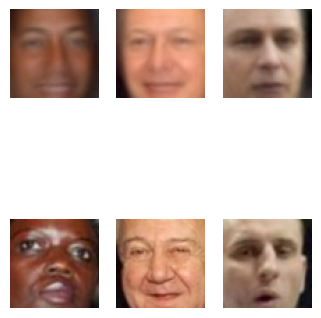

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


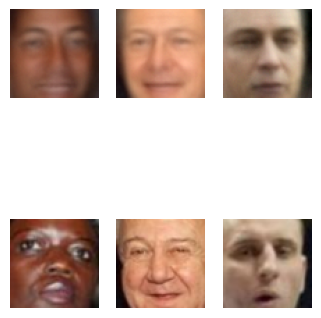

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


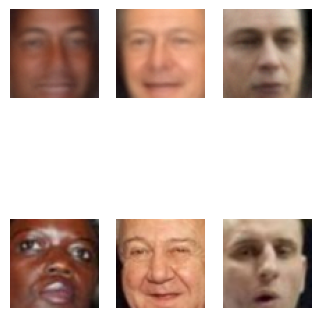

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


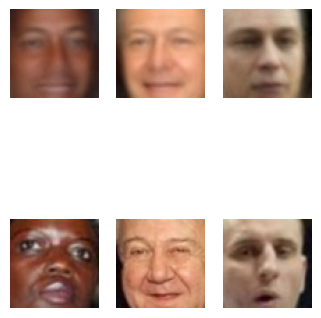

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


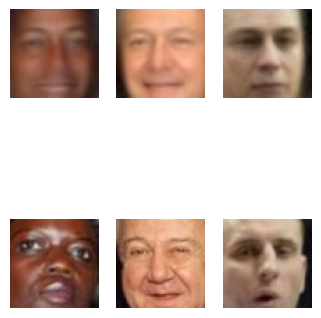

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


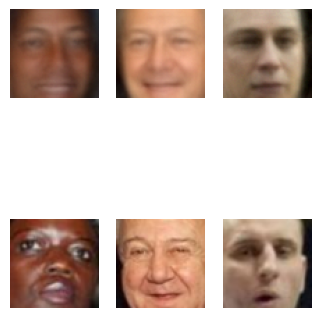

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


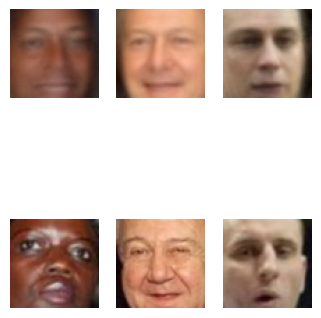

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


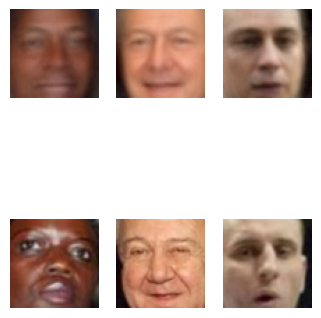

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


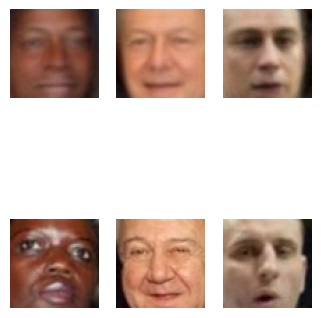

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


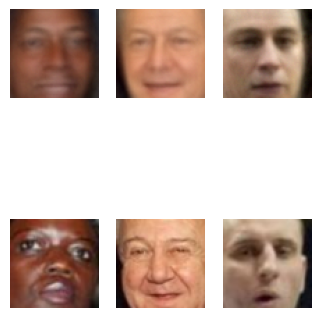

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


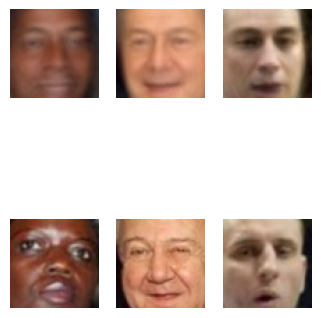

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


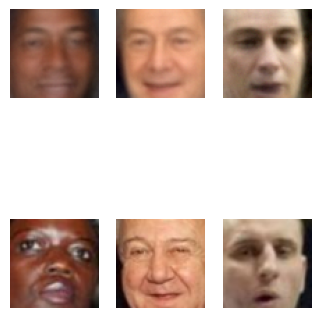

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


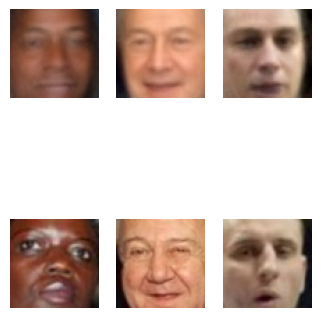

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


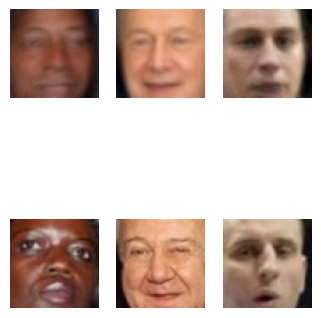

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


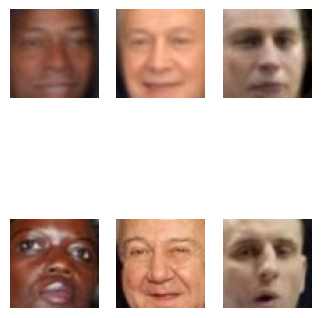

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


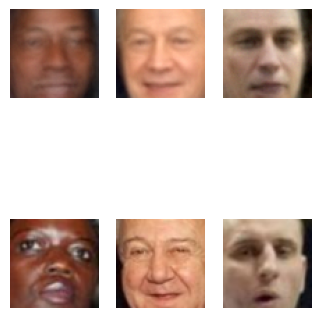

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


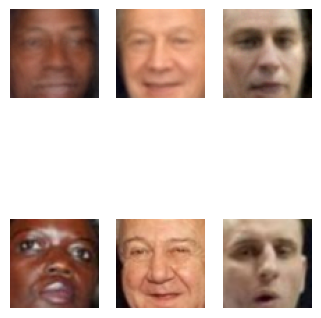

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


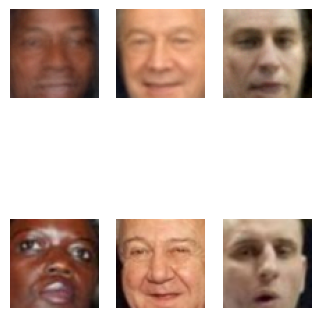

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


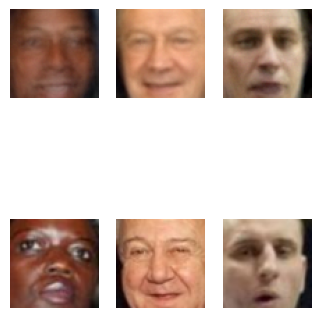

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


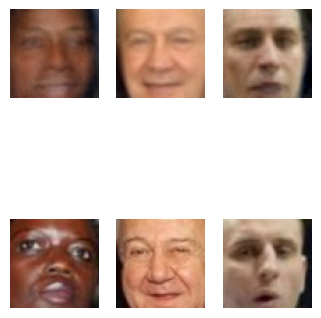

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


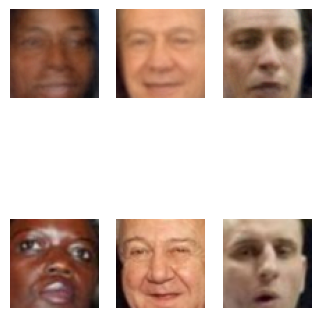

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


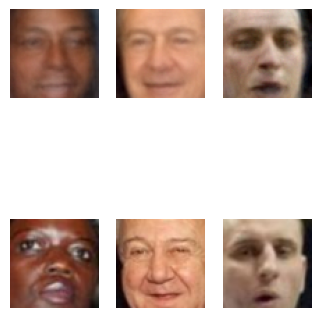

train iter::   0%|          | 0/370 [00:00<?, ?it/s]

val iter::   0%|          | 0/42 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


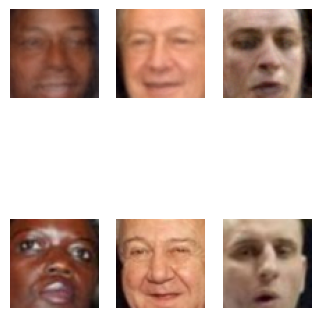

In [10]:


lat_space = []
#since = time.time()
pbar = trange(n_epochs, desc="Epoch:")
for epoch in pbar:
    for mode in modes:
        if mode == 'train':
            model.train()
            train_loss_per_epoch = 0
            for tr_batch in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                optimizer.zero_grad()
                reconstruction = model(tr_batch.to(device))[0]
                reconstruction = reconstruction.view(-1, 64, 64, 3)
                loss =  criterion(reconstruction, tr_batch.to(device).float())
                loss.backward()
                optimizer.step()
                train_loss_per_epoch += loss.item()
            train_loss.append( train_loss_per_epoch / len(dataloaders[mode]) )
            
        if mode == 'val':
            model.eval()
            val_loss_per_epoch = 0
            with torch.no_grad():
                for val_batch in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                    reconstruction, lat_vec = model(val_batch.to(device))
                    reconstruction = reconstruction.view(-1, 64, 64, 3)
                    lat_space.append(lat_vec)
                    loss =  criterion(reconstruction, val_batch.to(device).float())
                    val_loss_per_epoch += loss.item()
                val_loss.append(val_loss_per_epoch / len(dataloaders[mode]) )  
    plt.figure(figsize=(8, 5))
    for i in range(3):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(reconstruction[i].cpu().numpy())
    
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        plt.imshow(val_batch[i])
    plt.show()

         

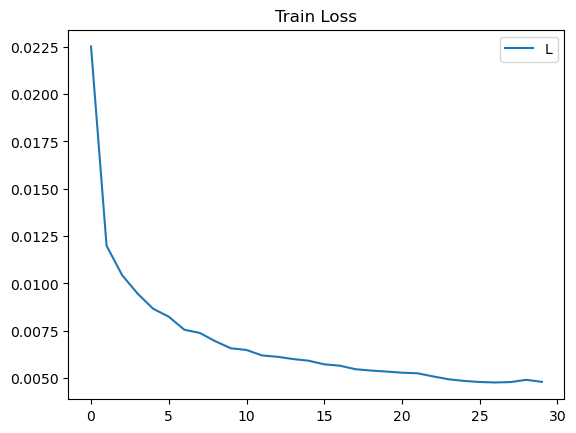

In [11]:
plt.plot(train_loss)
plt.title('Train Loss')
plt.legend('Loss')

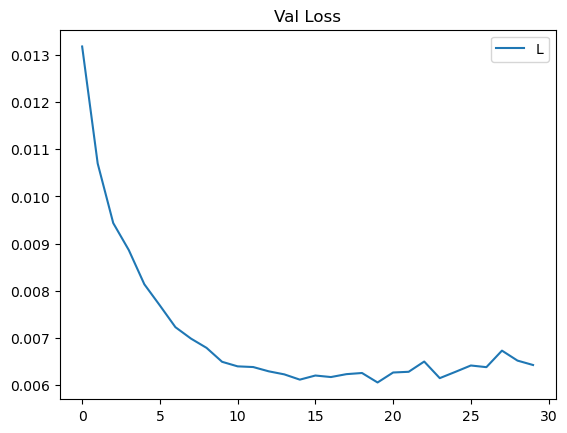

In [12]:
plt.plot(val_loss)
plt.title('Val Loss')
plt.legend('Loss')

In [15]:
for i in val_loader:
    print(i.shape)
    break

torch.Size([32, 64, 64, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


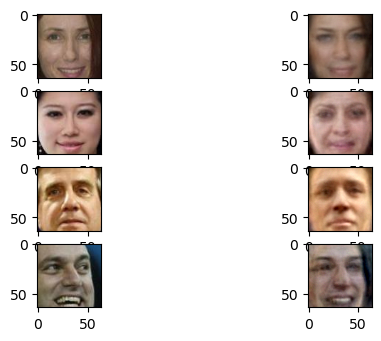

In [16]:
for i in val_loader:
    for i, (gt, res) in enumerate(zip(i[4:8], model(i[4:8].to(device))[0].view(-1, 64, 64, 3) )):
        plt.subplot(5, 2, 2*i+1)
        plt.imshow(gt)
        plt.subplot(5, 2, 2*i+2)
        plt.imshow(res.cpu().detach().numpy())
    break    

## 1.4. Sampling (2 балла)
Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Подсказка:Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [17]:
def sample_generator(mean_vec, std_vec):
    sample = np.zeros_like(mean_vec)
    for i in range(len(sample)):
        sample[i] += np.random.normal(mean_vec[i] , std_vec[i])
    return sample

In [18]:
total_space = lat_space[0].cpu().numpy()
for i in range(len(lat_space)): #Собираем все латентные вектора воедино
    total_space = np.concatenate( ( total_space, lat_space[i].cpu().numpy() ) )
    
mean_vec = np.mean(total_space, axis=0)
std_vec = np.std(total_space, axis=0)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


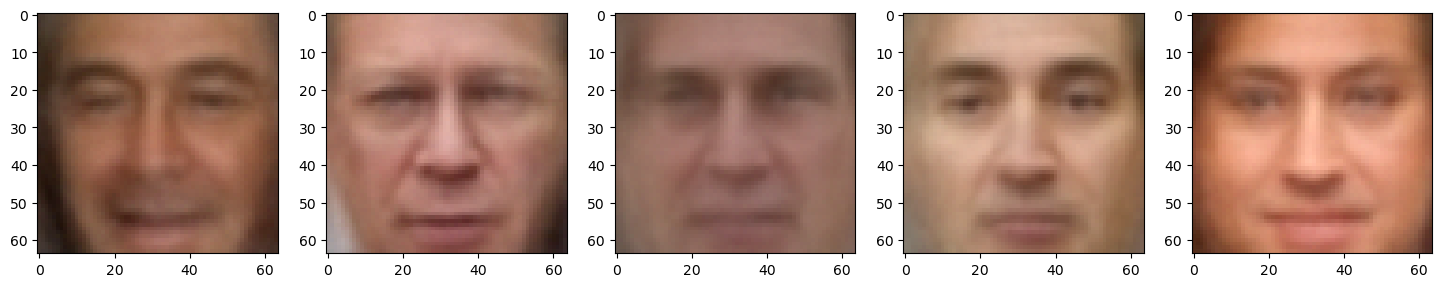

In [19]:
plt.figure(figsize=(18, 5))
for i in range(5): #геренатор случайного вектора с параметрами mean_vec, std_vec
    sample = sample_generator(mean_vec, std_vec)
    plt.subplot(1, 5, i + 1)
    plt.imshow(model.decoder(torch.tensor(sample).to(device)).view(64, 64, 3).cpu().detach().numpy())

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

#### Улыбающиеся

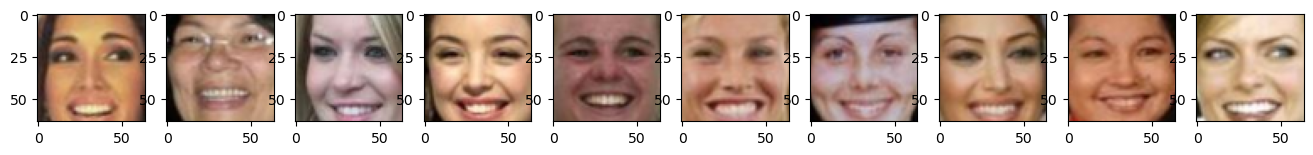

In [20]:
smile = list( attrs[attrs.Smiling > 2.6].index )


plt.figure(figsize=(18, 5))
a = len(smile[:10])
for i in range(a):
    plt.subplot(1, 11, i + 1)
    plt.imshow(data[smile[i]])

#### Грустные

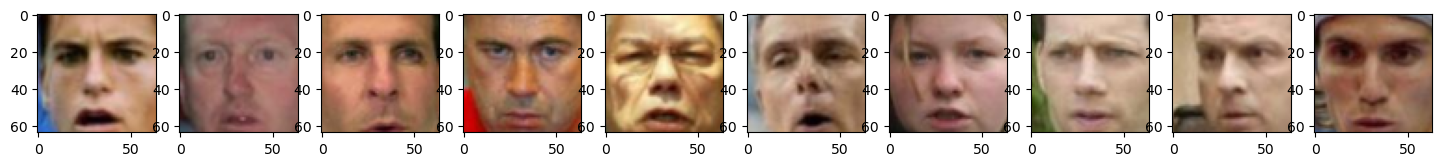

In [21]:
sad = list(attrs[attrs.Smiling < -2.45 ].index)

plt.figure(figsize=(18, 5))
a = len(sad[:10])
for i in range(a):
    plt.subplot(1, 10, i + 1)
    plt.imshow(data[sad[i]])

##### Распределение латентного пространства для улыбающихся

In [22]:
smiling_batch = torch.Tensor( np.array([data[i] for i in smile ]) ).to(device)
x = model.flatten(smiling_batch)
latetnt_smile = model.encoder(x).cpu().detach().numpy()

mean_smile_vec = np.mean(latetnt_smile, axis=0)
std_smile_vec = np.std(latetnt_smile, axis=0)  

##### Распределение латентного вектора для грустных

In [23]:
sad_batch = torch.Tensor( np.array([data[i] for i in sad ]) ).to(device)
x = model.flatten(sad_batch)
latetnt_sad = model.encoder(x).cpu().detach().numpy()

mean_sad_vec = np.mean(latetnt_sad, axis=0)
std_sad_vec = np.std(latetnt_sad, axis=0)

### Для начала попробуем погенерировать улыбающиеся и грустные лица

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


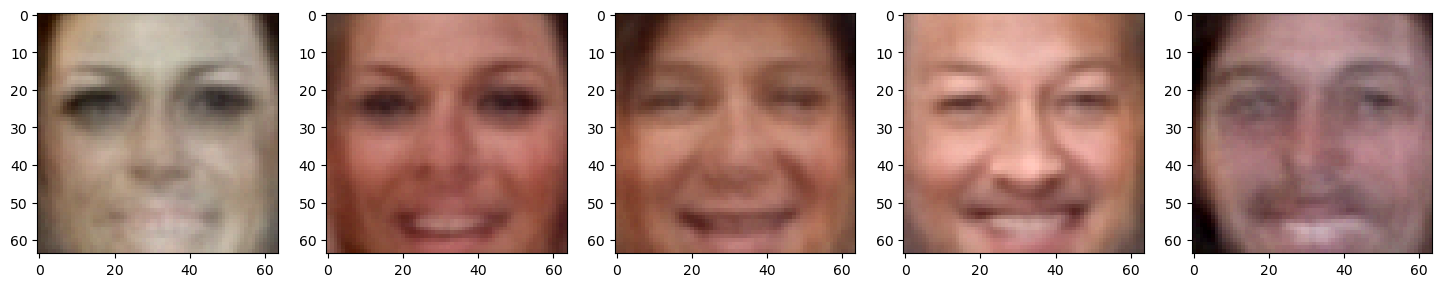

In [24]:
plt.figure(figsize=(18, 5))
for i in range(5):
    sample = sample_generator(mean_smile_vec, std_smile_vec)
    plt.subplot(1, 5, i + 1)
    plt.imshow(model.decoder(torch.tensor(sample).to(device)).view(64, 64, 3).cpu().detach().numpy())

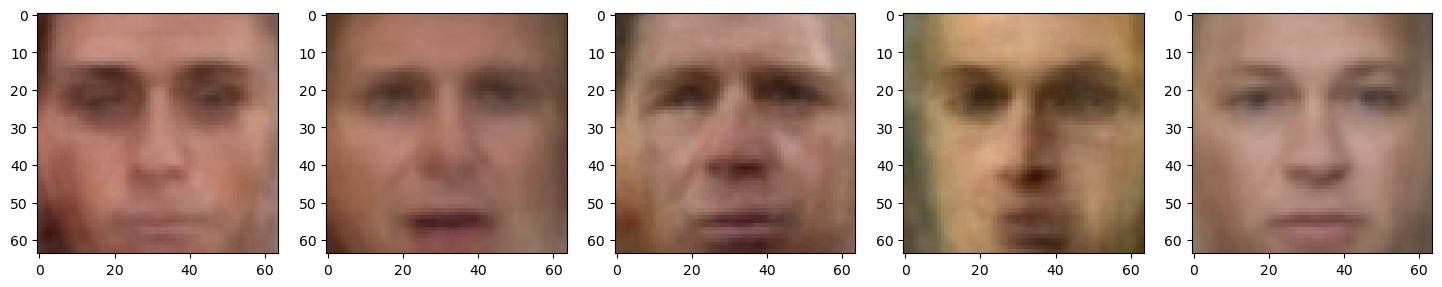

In [25]:
plt.figure(figsize=(18, 5))
for i in range(5):
    sample = sample_generator(mean_sad_vec, std_sad_vec)
    plt.subplot(1, 5, i + 1)
    plt.imshow(model.decoder(torch.tensor(sample).to(device)).view(64, 64, 3).cpu().detach().numpy())

### Вроде бы паттерн улыбки запонмить удалось. Далее сделаем из грустных людей - улыбающихся.

##### Получим вектор улыбки и затем сложим его с некоторыми грустными лицами:

In [26]:
# Получаем вектор улыбки и затем конвертируем латентное пространство грустных людей
smile_vec = mean_smile_vec - mean_sad_vec 
from_sad_to_smile = (latetnt_sad + smile_vec )

In [27]:
# Собираем тензора грустных людей и их же, но весёлыми 
sad_photos = model.decoder(torch.Tensor(latetnt_sad).to(device)).view(-1, 64, 64, 3)
from_sad_to_smile_photos = model.decoder(torch.Tensor(from_sad_to_smile).to(device)).view(-1, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


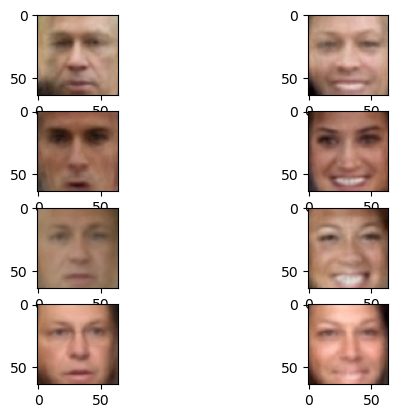

In [28]:
for i in val_loader:
    for i, (gt, res) in enumerate(zip(sad_photos[8:12], from_sad_to_smile_photos[8:12])):
        plt.subplot(4, 2, 2*i+1)
        plt.imshow(gt.cpu().detach().numpy())
        plt.subplot(4, 2, 2*i+2)
        plt.imshow(res.cpu().detach().numpy())
    break    

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в all_attrs

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [29]:
torch.cuda.empty_cache()
gc.collect()

87788

In [30]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!


    
<img src="https://s1.hostingkartinok.com/uploads/images/2023/12/fcf108eef2129dcc4e18795e4a40e616.jpg" alt="VAE">   

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder1 = nn.Sequential(
                        nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), #1/28/28 => 3/14/14
                        nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), # 3/14/14 => 6/7/7
                        nn.Conv2d(6, 12, kernel_size=2, stride=1), #6/7/7 => 12/6/6
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), #12/6/6 => 12/3/3
                        )
                       
        self.encoder2 = nn.Sequential(    
                        nn.Linear(108, 54),
                        nn.Linear(54, 2*20) 
                        )
        self.decoder1 = nn.Sequential(
                        nn.Linear(20, 54),
                        nn.ReLU(),
                        nn.Linear(54, 108)
                        )
        self.decoder2 = nn.Sequential(
                        nn.ConvTranspose2d(12, 6, kernel_size=5),
                        nn.ReLU(),
                        nn.ConvTranspose2d(6, 3, kernel_size=8),
                        nn.ReLU(),
                        nn.ConvTranspose2d(3, 1, kernel_size=15)
                        )
    def encode(self, x):
        x1 = self.encoder1(x).view(-1, 1, 108)
        x2 = self.encoder2(x1).view(-1, 2, 20)
        mu = x2[:, 0, :]
        logsigma = x2[:, 1, :]
        return mu, logsigma
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального
            #распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            rand_vec = torch.randn_like(mu)
            sample =  mu + (rand_vec * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        z1 = self.decoder1(z).view(-1, 12, 3, 3)
        reconstruction = self.decoder2(z1)
        return reconstruction 
    
    def forward(self, x, training=True):
        self.training = training
        x1 = self.encoder1(x).view(-1, 1, 108) #Линейная часть энкодра
        x2 = self.encoder2(x1).view(-1, 2, 20) # Свёрточная часть энкодера 
        mu = x2[:, 0, :]
        logsigma = x2[:, 1, :]
        lat = self.gaussian_sampler(mu, logsigma) # Сэмплирование латентного вектора
        vec = self.decoder1(lat).view(-1, 12, 3, 3) # Линейный декодер
        reconstruction = F.sigmoid( self.decoder2(vec) )# Итоговая реконструкция
        return reconstruction, mu, logsigma 

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [32]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

dataloaders = {'train': train_loader , 'val': test_loader}

modes = ['train', 'val']

n_epochs = 50

train_loss = []
val_loss = []

In [34]:
lat_space = []
pbar = trange(n_epochs, desc="Epoch:")
for epoch in pbar:
    for mode in modes:
        if mode == 'train':
            autoencoder.train()
            train_loss_per_epoch = 0
            for tr_batch, y in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                optimizer.zero_grad()
                reconstruction, mu, logsigma  = autoencoder(tr_batch.to(device))
                loss =  criterion(tr_batch.to(device), mu, logsigma, reconstruction)
                loss.backward()
                optimizer.step()
                train_loss_per_epoch += loss.item()
            train_loss.append( train_loss_per_epoch / len(dataloaders[mode]) )
            
        if mode == 'val':
            autoencoder.eval()
            val_loss_per_epoch = 0
            with torch.no_grad():
                for val_batch, y in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                    reconstruction, mu, logsigma  = autoencoder(val_batch.to(device), training=False)
                    loss =  criterion(val_batch.to(device), mu, logsigma, reconstruction)
                    val_loss_per_epoch += loss.item()
                val_loss.append(val_loss_per_epoch / len(dataloaders[mode]) )  

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

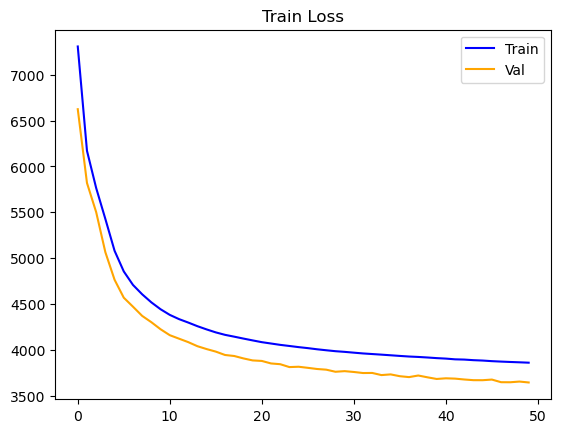

In [35]:
plt.plot(train_loss, color = 'Blue')
plt.plot(val_loss, color = 'Orange')
plt.title('Train Loss')
plt.legend(['Train','Val'])

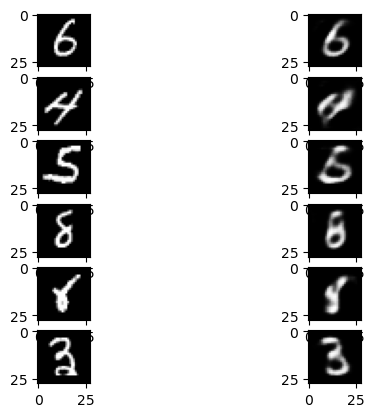

In [36]:
for i in train_loader:
    for i, (gt, res) in enumerate(zip(i[0][1:7], autoencoder(i[0].to(device))[0][1:7]   )):
        plt.subplot(6, 2, 2*i+1)
        plt.imshow(gt.cpu().view(28,28), cmap=plt.get_cmap('gray') )
        plt.subplot(6, 2, 2*i+2)
        plt.imshow(res.cpu().view(28,28).detach().numpy(), cmap=plt.get_cmap('gray') )
    break    

Попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

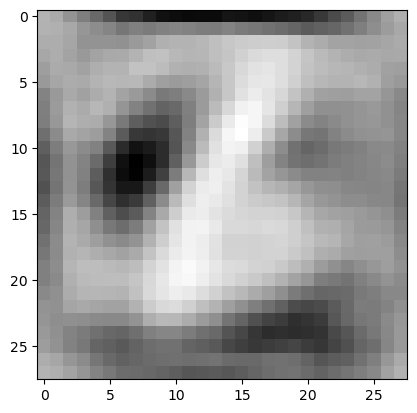

In [37]:
random_vec = torch.Tensor( np.random.normal(0,1,20) ).to(device)
random_sample = autoencoder.decode(random_vec).view(28,28)
plt.imshow(random_sample.cpu().detach().numpy() , cmap=plt.get_cmap('gray'))

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве. Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.

Итак, план:

Получить латентные представления картинок тестового датасета
С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [38]:
vec_list = []
class_list = []
for img in test_dataset:
    vec = autoencoder.encode(img[0].to(device))[0].cpu().detach().numpy()
    vec_list.append(vec[0])
    class_list.append(img[1])
vec_list = np.array(vec_list)
class_list = np.array(class_list)

In [39]:
print(vec_list.shape, class_list.shape)

(10000, 20) (10000,)


In [40]:
from sklearn.manifold import TSNE

tsne = TSNE()
low_dim_space = tsne.fit_transform(vec_list)
low_dim_space.shape

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdbed540900>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

(10000, 2)

In [41]:
low_dim_space = np.concatenate((low_dim_space, class_list[:,None]),axis=1)

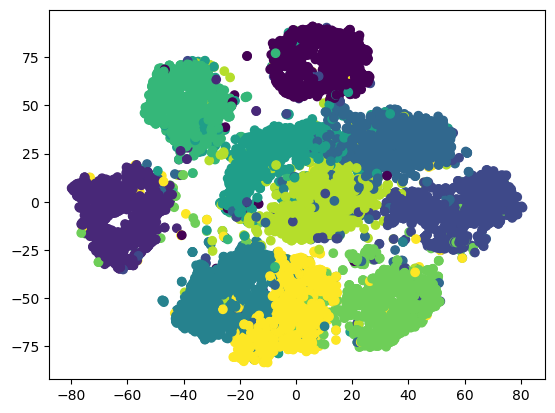

In [42]:
plt.scatter(low_dim_space[:,0], low_dim_space[:,1], c=low_dim_space[:,2])

Можно наблюдать хорошую структурированность по классам, однако я не могу назвать результат идеальным, так как точки лежат недостаточно плотно. Иными словами, хоть они и могут описываться стандартным Гауссовским многомерным распределением, но с определёнными оговорками
, например о том, что $\sigma^2$ не похожа на единичную. А вот $\mu$ действительно равна нулю 

## 2.3. Conditional VAE (6 баллов)

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов). Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

<p style="align: center;"><img align=center src="https://s1.hostingkartinok.com/uploads/images/2023/12/a1d6c68e718c5931764f6b5ba0e9a2c4.jpg" width=1000 height=1200/></p>

In [43]:
torch.cuda.empty_cache()
gc.collect()

# Матрица закодированных классов
one_hot_matrix = np.diag((1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
one_hot_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [44]:
class CVAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста",
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        self.encoder1 = nn.Sequential(
                        nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), #1/28/28 => 3/14/14
                        nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), # 3/14/14 => 6/7/7
                        nn.Conv2d(6, 12, kernel_size=2, stride=1), #6/7/7 => 12/6/6
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2), #12/6/6 => 12/3/3
                        )
        self.encoder2 = nn.Sequential(    
                        nn.Linear(118, 54),
                        nn.Linear(54, 2*20) 
                        )
        self.decoder1 = nn.Sequential(
                        nn.Linear(30, 54),
                        nn.ReLU(),
                        nn.Linear(54, 108)
                        )
        
        self.decoder2 = nn.Sequential(
                        nn.ConvTranspose2d(12, 6, kernel_size=5),
                        nn.ReLU(),
                        nn.ConvTranspose2d(6, 3, kernel_size=8),
                        nn.ReLU(),
                        nn.ConvTranspose2d(3, 1, kernel_size=15)
                        )
    def encode(self, x, class_num):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        x1 = self.encoder1(x).view(-1, 1, 108)
        onehot = torch.Tensor(one_hot_matrix[y]).view(x1.shape[0],-1,10)
        x1 = torch.cat((x1, onehot) ,2)
        x2 = self.encoder2(x1).view(-1, 2, 20)
        mu = x2[:, 0, :]
        logsigma = x2[:, 1, :]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training == True:
            #<засемплируйте латентный вектор из нормального
            #распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            rand_vec = torch.randn_like(mu)
            sample =  mu + (rand_vec * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        onehot = torch.Tensor(one_hot_matrix[class_num]).view(z.shape[0],-1,10)
        z = torch.cat((z, onehot) ,2)
        z1 = self.decoder1(z).view(-1, 12, 3, 3)
        reconstruction =  F.sigmoid( self.decoder2(z1) )
        return reconstruction

    def forward(self, x, y, training=True):
        self.training = training #Установка режима
        x1 = self.encoder1(x).view(-1, 1, 108) #1st encoder + reshape(batch, 1, 108)
        onehot = torch.Tensor(one_hot_matrix[y.cpu()]).view(x1.shape[0],-1,10).to(device) #OneHot + reshape(batch,1,10)
        x1 = torch.cat((x1, onehot) ,2) #Concatenation 1st encoder's output with onehot vec
        x2 = self.encoder2(x1).view(-1, 2, 20) #2nd encoder + reshaping to extract mu and sigma
        mu = x2[:, 0, :] #Extracting mu 
        logsigma = x2[:, 1, :] #Extracting sigma
        lat = self.gaussian_sampler(mu, logsigma).view(-1, 1, 20) #Sampling gaussian stohastic vector
        lat = torch.cat((lat, onehot) ,2) # Concating stohastic vector with onehot vector
        reconstruction = self.decoder1(lat).view(-1, 12, 3, 3) #1st decoder
        reconstruction = F.sigmoid( self.decoder2(reconstruction) ) #2nd decoder + sogmoid function
        return reconstruction, mu, logsigma

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=3e-4)

dataloaders = {'train': train_loader , 'val': test_loader}

modes = ['train', 'val']

n_epochs = 50

train_loss = []
val_loss = []

In [46]:
lat_space = []
pbar = trange(n_epochs, desc="Epoch:")
for epoch in pbar:
    for mode in modes:
        if mode == 'train':
            autoencoder.train()
            train_loss_per_epoch = 0
            for tr_batch, y in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                optimizer.zero_grad()
                reconstruction, mu, logsigma  = autoencoder(tr_batch.to(device), y.to(device))
                loss =  criterion(tr_batch.to(device), mu, logsigma, reconstruction)
                loss.backward()
                optimizer.step()
                train_loss_per_epoch += loss.item()
            train_loss.append( train_loss_per_epoch / len(dataloaders[mode]) )
            
        if mode == 'val':
            autoencoder.eval()
            val_loss_per_epoch = 0
            with torch.no_grad():
                for val_batch, y in tqdm(dataloaders[mode], leave=False, desc=f"{mode} iter:"):
                    reconstruction, mu, logsigma  = autoencoder(val_batch.to(device),y, training=False)
                    loss =  criterion(val_batch.to(device), mu, logsigma, reconstruction)
                    val_loss_per_epoch += loss.item()
                val_loss.append(val_loss_per_epoch / len(dataloaders[mode]) )  

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

train iter::   0%|          | 0/1875 [00:00<?, ?it/s]

val iter::   0%|          | 0/313 [00:00<?, ?it/s]

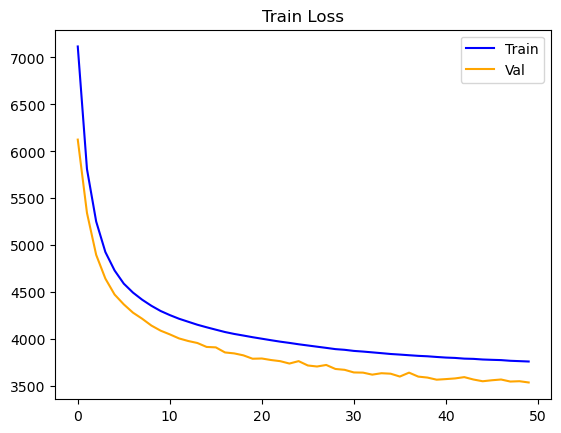

In [47]:
plt.plot(train_loss, color = 'Blue')
plt.plot(val_loss, color = 'Orange')
plt.title('Train Loss')
plt.legend(['Train','Val'])

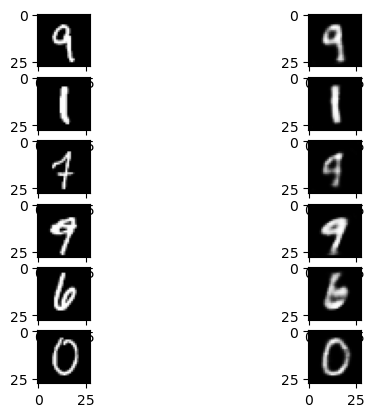

In [48]:
for i in train_loader:
    for i, (gt, res) in enumerate(zip(i[0][1:7], autoencoder(i[0].to(device),i[1].to(device))[0][1:7]  )):
        plt.subplot(6, 2, 2*i+1)
        plt.imshow(gt.cpu().view(28,28), cmap=plt.get_cmap('gray') )
        plt.subplot(6, 2, 2*i+2)
        plt.imshow(res.cpu().view(28,28).detach().numpy(), cmap=plt.get_cmap('gray') )
    break    

Тут мы будем сэмплировать из CVAE. Это лучше, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов! Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

### Генерация своих изображений с определённым классом
### Sampling


In [49]:
def CVAE_sample_generator():
    random_class = np.random.randint(0,10)
    random_vec = torch.Tensor( np.random.normal(0,1,20) ).view(1,-1,20).to(device)
    
    onehot = torch.Tensor(one_hot_matrix[random_class]).view(1,-1,10).to(device)
    z = torch.cat((random_vec, onehot) ,2)
    z1 = autoencoder.decoder1(z).view(-1, 12, 3, 3)
    reconstruction =  F.sigmoid( autoencoder.decoder2(z1) ).view(1,28,28)
    reconstruction = reconstruction.cpu().detach().permute(1,2,0).numpy()
    return reconstruction, random_class


3
5
2
2
8


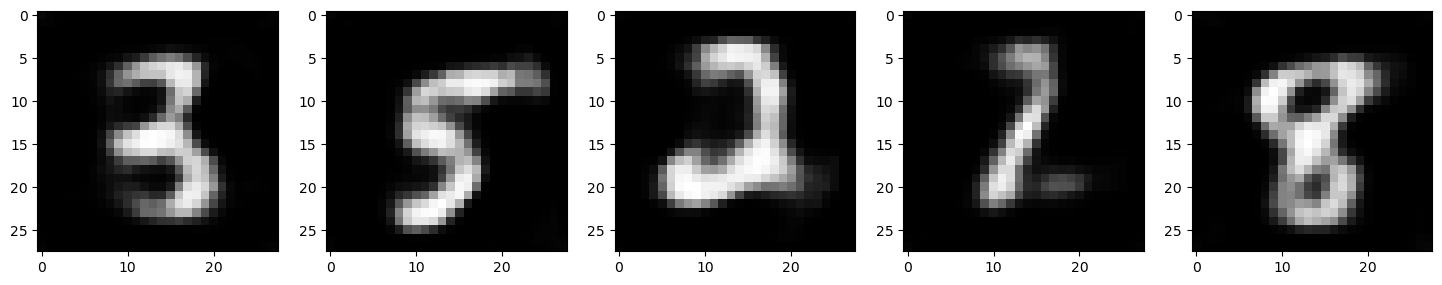

In [50]:
plt.figure(figsize=(18, 5))
for i in range(5):
    sample, random_class = CVAE_sample_generator()
    print(random_class)
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample, cmap=plt.get_cmap('gray'))

## Latent Representations

Посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE 

Опять же, покрасим точки в разные цвета в зависимости от класса.

In [51]:
vec_list = []
class_list = []
for img in test_dataset:
    x1 = autoencoder.encoder1(img[0].to(device)).view(-1, 1, 108)
    onehot = torch.Tensor(one_hot_matrix[img[1]]).view(x1.shape[0],-1,10).to(device)
    x1 = torch.cat((x1, onehot) ,2)
    x2 = autoencoder.encoder2(x1).view(-1, 2, 20)
    mu = x2[:, 0, :]
    vec_list.append(mu.cpu().detach().numpy())
    class_list.append(img[1])
vec_list = np.array(vec_list).reshape(-1,20)
class_list = np.array(class_list)

In [52]:
print(vec_list.shape, class_list.shape)

(10000, 20) (10000,)


In [53]:
from sklearn.manifold import TSNE

tsne = TSNE()
low_dim_space = tsne.fit_transform(vec_list)
low_dim_space.shape

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdbe01831a0>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/daniil/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

(10000, 2)

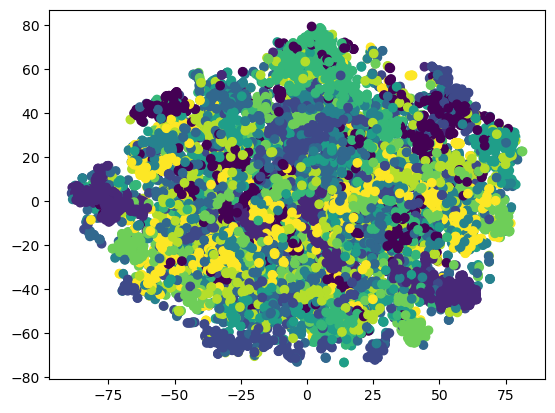

In [54]:
low_dim_space = np.concatenate((low_dim_space, class_list[:,None]),axis=1)
plt.scatter(low_dim_space[:,0], low_dim_space[:,1], c=low_dim_space[:,2])

# Вывод:
Заметно два основных отличия латентного пространства VAE и CVAE: У VAE оно больше структурированно с точки зрения кластеров, однако было более разрозненным и не так хорошо описывалось Гауссовским распределением. В случае CVAE у нас отчётливо виден Гауссовский закон, однако пропала кластеризация, что неудивительно: на каждом проходе мы в какой то степени мешали нашей сети, подсовывая энкодеру one-hot вектор, который тут не ожидал увидеть и, как следствие, это вносило корректировки в вид латентного пространства. Однако это не является плохим знаком, так как здесь мы приобрели гораздо более важное свойство: у нас получилось компактное латентное пространство, в котором нет проблелов и которое хорошо описывается нормальным распределением . Как следствие - при попытке сгенерировать случайное изображение у нас есть сильные гарантии того, что мы получим осознанное изображение(существущую цифру в нашем случае), а не какую-то сумбурную мешанину. А недостаток отсутсвия кластерности мы поправим тем, что на вход декодеру засунем не просто латентный вектор, а перед этим сконкатенируем его с one-hot вектором, который явным образом укажет необходимый класс !